# Multiple linear regression model
### Let's mimic the process of building our trading model of SPY, base on the historical data of different stock markets

In [31]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
# import all stock market data into DataFrame
aord = pd.read_csv('../data/indice/ALLOrdinary.csv')
nikkei = pd.read_csv('../data/indice/Nikkei225.csv')
hsi = pd.read_csv('../data/indice/HSI.csv')
daxi = pd.read_csv('../data/indice/DAXI.csv')
cac40 = pd.read_csv('../data/indice/CAC40.csv')
sp500 = pd.read_csv('../data/indice/SP500.csv')
dji = pd.read_csv('../data/indice/DJI.csv')
nasdaq =pd.read_csv('../data/indice/nasdaq_composite.csv')
spy = pd.read_csv('../data/indice/SPY.csv')

## Step 1: Data Munging

In [34]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model

indicepanel = pd.DataFrame(index=spy.index)
indicepanel['spy'] = spy['Open'].shift(-1) - spy['Open']
indicepanel['spy_lag1'] = indicepanel['spy'].shift(1)
indicepanel['sp500'] = sp500['Open'] - sp500['Open'].shift(1)
indicepanel['nasdaq'] = nasdaq['Open'] - nasdaq['Open'].shift(1)
indicepanel['dji'] = dji['Open'] - dji['Open'].shift(1)

indicepanel['cac40'] = cac40['Open'] - cac40['Open'].shift(1)
indicepanel['daxi'] = daxi['Open'] - daxi['Open'].shift(1)

indicepanel['aord'] = aord['Close'] - aord['Open']
indicepanel['hsi'] = hsi['Close'] - hsi['Open']
indicepanel['nikkei'] = nikkei['Close'] - nikkei['Open']

indicepanel['Price'] = spy['Open']

In [35]:
# Lets check whether do we have NaN values in indicepanel
indicepanel.isnull().sum()

spy          1
spy_lag1     1
sp500        1
nasdaq       1
dji          1
cac40        3
daxi        11
aord         2
hsi         57
nikkei      57
Price        0
dtype: int64

In [36]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the reminding Nan values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [37]:
# Lets check whether do we have Nan values in indicepanel now
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [38]:
# save this indicepanel for part 4.5
path_save = '../data/indice/indicepanel.csv'
indicepanel.to_csv(path_save)

In [39]:
print(indicepanel.shape)

(2678, 11)


## Step 2: Data Spliting

In [40]:
#split the data into (1)train set and (2)test set

Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

(1000, 11) (1000, 11)


## Step 3: Explore the train data set

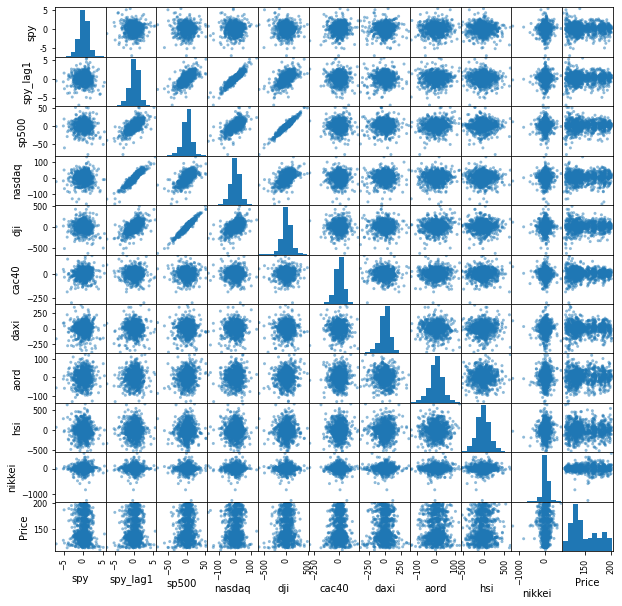

In [41]:
# Generate scatter matrix among all stock markets (and the price of SPY) to observe the association

from pandas.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))

## Step 4: Find the top five correlated indice to SPY

In [42]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy']
corr_array_sorted = np.abs(corr_array).sort_values(ascending=False)[1:] # We ignore the first highest, which is SPY, the correlation to itself is always 1, the highest.
print(corr_array_sorted[:5])

cac40     0.076886
aord      0.048200
hsi       0.038361
dji       0.037097
nikkei    0.035379
Name: spy, dtype: float64


In [43]:
formula = 'spy~aord+cac40+nikkei+dji+daxi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.413
Date:                Wed, 26 Jul 2023   Prob (F-statistic):             0.0347
Time:                        18:04:19   Log-Likelihood:                -1646.6
No. Observations:                1000   AIC:                             3305.
Df Residuals:                     994   BIC:                             3335.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0878      0.040      2.199      0.028       0.009       0.166
aord           0.0019      0.001      1.640      0.101      -0.000       0.004
cac40          0.0021      0.001      2.477      0.013       0.000       0.004
nikkei         0.0004      0.000      1.215      0.225      -0.000       0.001
dji           -0.0005      0.000     -1.381      0.167      -0.001       0.000
daxi           0.0003      0.000      0.765      0.444      -0.001       0.001
==============================================================================
Omnibus:                       88.176   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.583
Skew:                          -0.435   Prob(JB):                     7.07e-57
Kurtosis:                       5.334   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 5: Make prediction

In [44]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

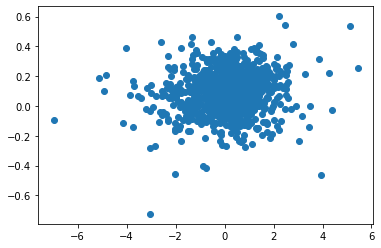

In [45]:
plt.scatter(Train['spy'], Train['PredictedY'])

## Step 6: Model evaluation - Statistical standard

We can measure the performance of our model using some statistical metrics - **RMSE**, **Adjusted $R^2$ **

In [46]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'].mean())**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [47]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [48]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 5, 'spy')

,Train,Test
R2,0.007020,0.005121
RMSE,1.267109,1.742535


We can see that the adjusted $R^2$ drops and the RMSE increases in test. It is not as consistent as the model we demostrated in the lecture.